In [1]:
!pip install -qU langchain langchain-community langchain-openai youtube-transcript-api pytube langchain-chroma


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
from dotenv import load_dotenv

# load settings
load_dotenv()

True

# Load Documents
---
`YouTubeLoader`를 이용해 YouTube에 업로드된 LangChain 비디오의 내용을 로드할 수 있다.

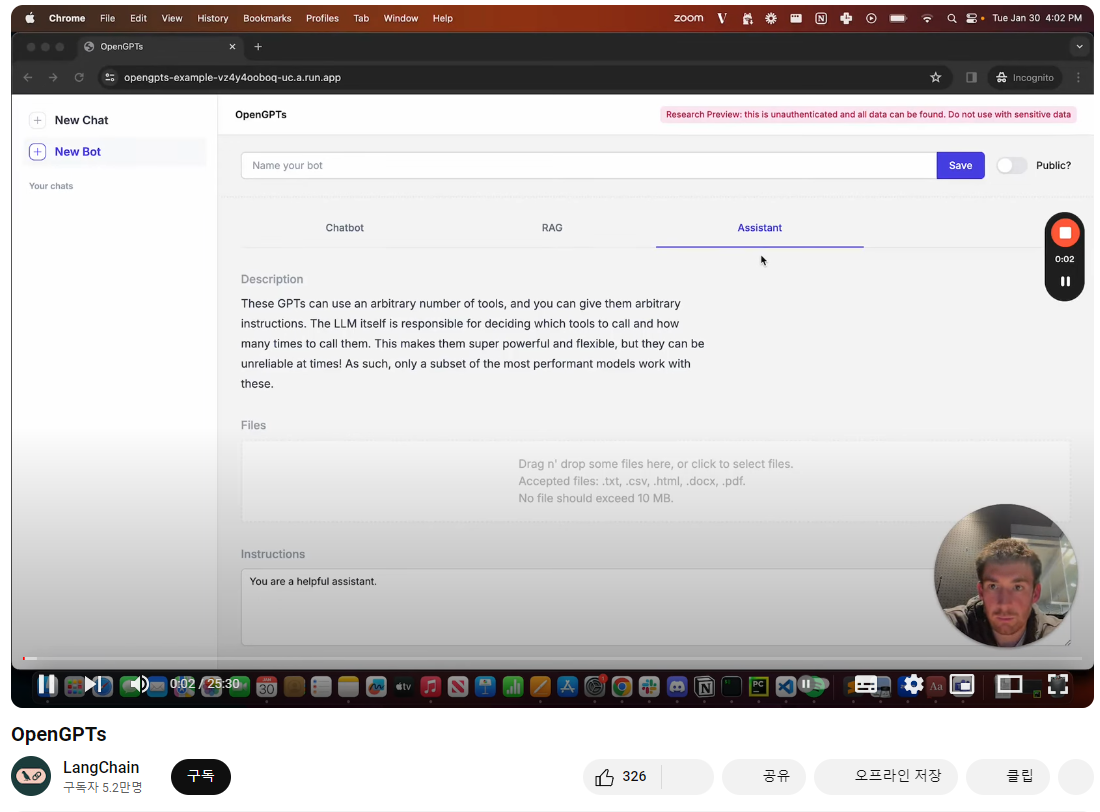

In [2]:
from langchain_community.document_loaders import YoutubeLoader

# LangChain과 관련된 영상 리스트
urls = [
    "https://www.youtube.com/watch?v=HAn9vnJy6S4",
    "https://www.youtube.com/watch?v=dA1cHGACXCo",
    "https://www.youtube.com/watch?v=ZcEMLz27sL4",
    "https://www.youtube.com/watch?v=hvAPnpSfSGo",
    "https://www.youtube.com/watch?v=EhlPDL4QrWY",
    "https://www.youtube.com/watch?v=mmBo8nlu2j0",
    "https://www.youtube.com/watch?v=rQdibOsL1ps",
    "https://www.youtube.com/watch?v=28lC4fqukoc",
    "https://www.youtube.com/watch?v=es-9MgxB-uc",
    "https://www.youtube.com/watch?v=wLRHwKuKvOE",
    "https://www.youtube.com/watch?v=ObIltMaRJvY",
    "https://www.youtube.com/watch?v=DjuXACWYkkU",
    "https://www.youtube.com/watch?v=o7C9ld6Ln-M",
]
docs = []
for url in urls:
    docs.extend(YoutubeLoader.from_youtube_url(url, add_video_info=True).load())

In [7]:
# 첫번째 유튜브 문서의 정보

docs[0].metadata

{'source': 'HAn9vnJy6S4',
 'title': 'OpenGPTs',
 'description': 'Unknown',
 'view_count': 9133,
 'thumbnail_url': 'https://i.ytimg.com/vi/HAn9vnJy6S4/hq720.jpg',
 'publish_date': '2024-01-31 00:00:00',
 'length': 1530,
 'author': 'LangChain'}

In [9]:
# 유튜브 자막의 일부

docs[0].page_content[:500]

"hello today I want to talk about open gpts open gpts is a project that we built here at linkchain uh that replicates the GPT store in a few ways so it creates uh end user-facing friendly interface to create different Bots and these Bots can have access to different tools and they can uh be given files to retrieve things over and basically it's a way to create a variety of bots and expose the configuration of these Bots to end users it's all open source um it can be used with open AI it can be us"

# Indexing Documents
---

In [11]:
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
chunked_docs = text_splitter.split_documents(docs)
embeddings = HuggingFaceEmbeddings()
vectorstore = Chroma.from_documents(
    chunked_docs,
    embeddings,
)

C:\Users\hyundai\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
C:\Users\hyundai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\hyundai\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will

In [12]:
search_results = vectorstore.similarity_search("How do i build a RAG agent")

In [13]:
print(search_results[0].metadata["title"])

OpenGPTs


In [15]:
print(search_results[0].page_content[:500])

from the documents so that is the so those are the three types of um Bots that we have they're all put together in this agent file and this is where we also start to use um uh uh configuration basically so configurable fields and configurable alternatives are something that exists in linkchain and they're really handy when you want end users to be able to configure things or sometimes when you want to do the configuration on the Fly for example if you want to randomly select a model to use and y


In [16]:
search_results = vectorstore.similarity_search("videos on RAG published in 2023")
print(search_results[0].metadata["title"])
print(search_results[0].metadata["publish_date"])
print(search_results[0].page_content[:500])

Getting Started with Multi-Modal LLMs
2023-12-20 00:00:00
GPD 4V and some other models that we'll talk about today um so kind of a quick overview of models a lot of this work of course of course you know predates uh you know the current year of 2023 uh it's probably worth noting clip it's very important work from open AI um that kind of map data from different modalities text and images into a shared embedding space um it's open source and actually clip embeddings are still used uh for visual encoding in models that you'll see today for example lava um


# Query analysis
---

사용자의 질문을 구조화된 쿼리로 변환하는 `쿼리 분석` 과정을 통해 검색 결과를 개선할 수 있다.

## Query schema
---

필터링 옵션에 사용할 게시 날짜에 대한 최소, 최대 속성을 명시적으로 지정할 수 있다.

In [23]:
from typing import Optional

from langchain_core.pydantic_v1 import BaseModel, Field


class Search(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    query: str = Field(
        ..., # 필수 값 지정
        description="Similarity search query applied to video transcripts.",
    )
    publish_year: Optional[int] = Field(None, description="Year video was published")

## Query generation
---

- 사용자 쿼리를 구조적으로 변환하기 위해 `google ai`를 이용한다.
- `ChatModel.with_structured_output()` 생성자를 이용해 모델에 스키마를 전달하고 출력을 파싱한다.
- gemini 모델은 쿼리분석을 지원하지 않음.

In [55]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a list of database queries optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm.with_structured_output(Search)
query_analyzer = {"question": RunnablePassthrough()} | prompt | structured_llm

In [57]:
query_analyzer.invoke("videos on RAG published in 2023")
>>>Search(query='build RAG agent', publish_year=None)

SyntaxError: invalid syntax (1668557653.py, line 2)

In [58]:
query_analyzer.invoke("videos on RAG published in 2023")
>>>Search(query='RAG', publish_year=2023)

SyntaxError: invalid syntax (3508592877.py, line 2)

# Retrieval with Query Analysis
---



In [59]:
from typing import List

from langchain_core.documents import Document

In [60]:
def retrieval(search: Search) -> List[Document]:
    if search.publish_year is not None:
        # This is syntax specific to Chroma,
        # the vector database we are using.
        _filter = {"publish_year": {"$eq": search.publish_year}}
    else:
        _filter = None
    return vectorstore.similarity_search(search.query, filter=_filter)

In [61]:
retrieval_chain = query_analyzer | retrieval

In [62]:
results = retrieval_chain.invoke("RAG tutorial published in 2023")

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [63]:
[(doc.metadata["title"], doc.metadata["publish_date"]) for doc in results]
>>>[('Getting Started with Multi-Modal LLMs', '2023-12-20 00:00:00'),
 ('LangServe and LangChain Templates Webinar', '2023-11-02 00:00:00'),
 ('Getting Started with Multi-Modal LLMs', '2023-12-20 00:00:00'),
 ('Building a Research Assistant from Scratch', '2023-11-16 00:00:00')]

SyntaxError: invalid syntax (1339183383.py, line 2)